# GraphSAGE experiment for graph classification

Paper: https://proceedings.neurips.cc/paper/2017/file/5dd9db5e033da9c6fb5ba83c7a7ebea9-Paper.pdf
<br>Article: https://medium.com/p/a9e7f9ecf9d7

In [168]:
import torch
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

In [169]:
dataset = TUDataset(root="../data/TUDataset", name='COLLAB')

In [3]:
# set CUDA
device = "cuda:0" if (torch.cuda.is_available()) else "cpu"
device

'cuda:0'

Preprocessing (degree)

In [187]:
max_degree = 0
degs = []
for data in dataset:
    deg = torch_geometric.utils.degree(data.edge_index[1], num_nodes=data.num_nodes)
    degs.extend(deg.numpy())
    max_degree = max(max_degree, max(deg).item())
# assign to one hot degree for each data (OneHotDegree receive maximum degree parameter)
dataset.transform = torch_geometric.transforms.OneHotDegree(int(max_degree))

EDA

In [55]:
dict_degs = {}
for d in degs:
    if d not in dict_degs:
        dict_degs[d] = 1
    else:
        dict_degs[d] += 1
        
list_degs = []
list_num_degs = []

for d in dict_degs:
    list_degs.append(d)
    list_num_degs.append(dict_degs[d])

In [59]:
df_degs = pd.DataFrame(list(zip(list_degs, list_num_degs)), columns =['degree', 'count'])

In [89]:
df_degs[df_degs['count'] == 37231.0]

,degree,count
235,238.0,37231


In [103]:
df_degs = df_degs.sort_values(by='degree').reset_index(drop=True)
df_degs.head()

,degree,count
0,1.0,1796
1,2.0,5747
2,3.0,8594
3,4.0,9397
4,5.0,9599


<BarContainer object of 369 artists>

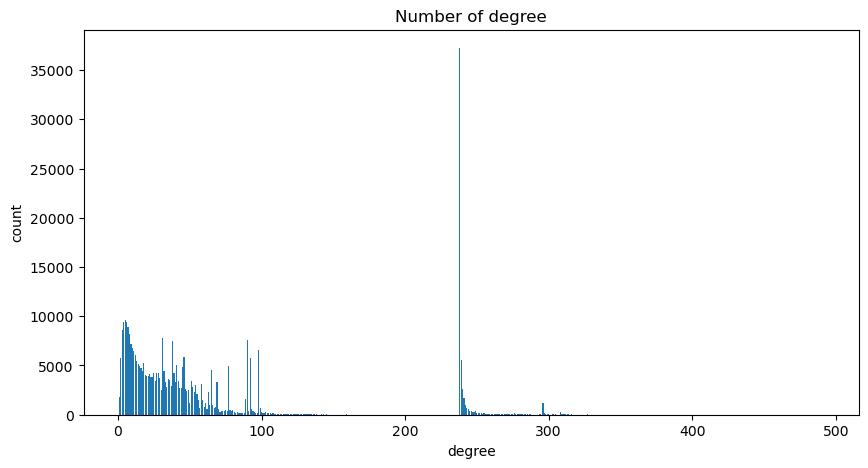

In [108]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('degree')
ax.set_ylabel('count')
ax.set_title('Number of degree')
plt.bar(df_degs['degree'],
        df_degs['count'])

Train Test Split

In [163]:
def train_test_split(dataset, ratio):
    random.shuffle(dataset)
    return dataset[:math.ceil(len(dataset) * ratio)], dataset[math.ceil(len(dataset) * ratio):]

In [164]:
cuda_dataset = []
for data in dataset:
    cuda_dataset.append(data.to(torch.device(device)))

In [170]:
train_dataset, test_dataset = train_test_split(cuda_dataset, 0.7)
print('train dataset len: ', len(train_dataset))
print('test dataset len: ', len(test_dataset))

train dataset len:  3500
test dataset len:  1500


In [171]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [172]:
train_dataset[0]

Data(edge_index=[2, 858], y=[1], num_nodes=54, x=[54, 492])

In [181]:
for tl in train_loader:
    print(tl.y)
    break
for tl in test_loader:
    print(tl.y)
    break

tensor([1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0], device='cuda:0')
tensor([2, 1, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2, 0, 2, 2, 0, 2,
        2, 1, 0, 0, 0, 2, 0, 0], device='cuda:0')


Building Model

In [183]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import global_mean_pool

In [215]:
class GCN(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(dataset.num_node_features, hidden_channels, 2)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels, 2)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels, 3)
        self.lin = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.5)
        x = self.lin(x)
        
        return x

In [216]:
model = GCN(dataset, 16)
model.to(torch.device(device))
model

GCN(
  (conv1): GraphSAGE(492, 16, num_layers=2)
  (conv2): GraphSAGE(16, 16, num_layers=2)
  (conv3): GraphSAGE(16, 16, num_layers=2)
  (lin): Linear(in_features=16, out_features=3, bias=True)
)

Train Test method

In [210]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model, loader):
    model.train()
    
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return out, loss

@torch.no_grad()
def test(model, loader):
    model.eval()
    correct = 0    
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

In [212]:
for epoch in range(1,30):
    _, loss = train(model, train_loader)
    train_acc = test(model, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.9600, Train Acc: 0.6094, Test Acc: 0.5980
Epoch: 002, Loss: 1.1496, Train Acc: 0.6083, Test Acc: 0.6040
Epoch: 003, Loss: 0.6303, Train Acc: 0.6091, Test Acc: 0.5940
Epoch: 004, Loss: 0.8979, Train Acc: 0.6077, Test Acc: 0.5933
Epoch: 005, Loss: 0.7264, Train Acc: 0.6063, Test Acc: 0.5967
Epoch: 006, Loss: 1.1900, Train Acc: 0.6054, Test Acc: 0.5993
Epoch: 007, Loss: 1.0435, Train Acc: 0.6123, Test Acc: 0.5973
Epoch: 008, Loss: 0.9294, Train Acc: 0.6120, Test Acc: 0.6053
Epoch: 009, Loss: 0.4620, Train Acc: 0.6091, Test Acc: 0.5920
Epoch: 010, Loss: 0.9956, Train Acc: 0.6071, Test Acc: 0.5993
Epoch: 011, Loss: 1.0970, Train Acc: 0.6109, Test Acc: 0.6027
Epoch: 012, Loss: 0.8279, Train Acc: 0.6063, Test Acc: 0.5973
Epoch: 013, Loss: 0.8929, Train Acc: 0.6000, Test Acc: 0.5980
Epoch: 014, Loss: 0.8922, Train Acc: 0.6089, Test Acc: 0.5967
Epoch: 015, Loss: 0.6459, Train Acc: 0.6060, Test Acc: 0.5967
Epoch: 016, Loss: 0.8842, Train Acc: 0.6089, Test Acc: 0.5900
Epoch: 0